# Applying LSTM

## Imports

In [66]:
# deep learning using pytorch and pytorch lightning
import torch
import torch.nn as nn
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinaryRecall, BinarySpecificity, BinaryAUROC
from torch.utils.data import DataLoader, Dataset, TensorDataset
import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

# data manipulation / preprocessing
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc

# logging
import logging
import logging.handlers

from scipy.fft import fft
from scipy.stats import kurtosis, skew, entropy, linregress, zscore, skew, kurtosis, shapiro
from scipy.spatial import distance
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

import random


# for checking file existance
import os

# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

## Setting seeds for reproducibility

In [67]:
random.seed(42)
np.random.seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42) 

In [68]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data download

In [2]:
ct_timeseries_df = pd.read_csv("./data/ingested/ct/CT_timeseries_long_format.csv")
ct_sample_types_df = pd.read_csv("./data/ingested/ct/CT_sample_types.csv")

covid_df = pd.read_csv("./data/ingested/covid_timeseries_data.csv")

complete_ct_df = pd.merge(ct_timeseries_df, ct_sample_types_df, on='sample_id', how='left')

### CT

In [3]:
complete_ct_df = complete_ct_df.dropna()

In [4]:
# normalisation
# ct_timeseries = complete_ct_df.groupby(['sample_id', 'replicate']).apply(
#     lambda x: (
#         (x.sort_values('mins')['value'].values[:45] - x['value'].min()) /
#         (x['value'].max() - x['value'].min())
#     ),
#     include_groups=False
# )

# standardisation
ct_timeseries = complete_ct_df.groupby(['sample_id', 'replicate']).apply(
    lambda x: (
        (x.sort_values('mins')['value'].values[:45] - x['value'].mean()) /
        x['value'].std()
    ),
    include_groups=False
)

In [5]:
series_to_remove = ct_timeseries[ct_timeseries.apply(lambda x: len(x) < 45)].index
ct_timeseries = ct_timeseries.drop(series_to_remove)

In [6]:
ct_outcomes = complete_ct_df.groupby(['sample_id', 'replicate']).apply(
    lambda x: x['result'].values[0],
    include_groups = False
)
ct_outcomes = ct_outcomes.drop(series_to_remove)

### COVID

In [33]:
# normalisation
covid_timeseries = covid_df.groupby(['sample']).apply(
    lambda x: (
        (x.sort_values('mins')['value'].values - x['value'].min()) /
        (x['value'].max() - x['value'].min())
    ),
    include_groups=False
)

# standardisation
# covid_timeseries = covid_df.groupby(['sample']).apply(
#     lambda x: (
#         (x.sort_values('mins')['value'].values - x['value'].mean()) /
#         x['value'].std()
#     ),
#     include_groups=False
# )

In [34]:
covid_outcomes = covid_df.groupby(['sample']).apply(
    lambda x: x['result'].values[0],
    include_groups = False
)

## Preprocessing

In [7]:
def extract_metrics(series):
    diff = np.diff(series)
    return {
        'std': np.std(series),
        'mean_abs_change': np.mean(np.abs(diff)),
        'autocorr': pd.Series(series).autocorr(lag=1)
    }

def total_variation(series):
    return np.sum(np.abs(np.diff(series)))

### CT

#### Outlier removal

In [88]:
metrics_df = pd.DataFrame([
    extract_metrics(ts) for ts in ct_timeseries
])

outlier_flags = (np.abs(zscore(metrics_df)) > 3).any(axis=1)
metric_outliers = metrics_df[outlier_flags]

In [89]:
tv_scores = [total_variation(ts) for ts in ct_timeseries]
variation_threshold = np.percentile(tv_scores, 92) # top 8% most erratic
variation_outlier_indices = [i for i, tv in enumerate(tv_scores) if tv > variation_threshold]

In [90]:
total_outliers = np.array(list(set(metric_outliers.index.values).union(variation_outlier_indices)))
# outlier_labels = ct_timeseries.index[total_outliers]
outlier_labels = ct_timeseries.index[metric_outliers.index.values]

In [91]:
cleaner_ct_timeseries = ct_timeseries.copy()
cleaner_ct_timeseries = cleaner_ct_timeseries.drop(outlier_labels)

cleaner_ct_outcomes = ct_outcomes.copy()
cleaner_ct_outcomes = cleaner_ct_outcomes.drop(outlier_labels)

In [59]:
print(f"Number of entries of original series: {len(ct_timeseries)}")
print(f"Number of entries of cleaned series: {len(cleaner_ct_timeseries)}")
print(f"Number of entries removed: {len(ct_timeseries)-len(cleaner_ct_timeseries)}")

Number of entries of original series: 279
Number of entries of cleaned series: 268
Number of entries removed: 11


#### Label encoding, data balancing and threshold data splitting

In [92]:
# label encoding
cleaner_ct_outcomes = cleaner_ct_outcomes.map({"positive":1, "negative":0})

In [93]:
# data balancing
X = cleaner_ct_timeseries.to_frame(name='timeseries')
y = cleaner_ct_outcomes

X_resampled, y_resampled = RandomUnderSampler(random_state=42).fit_resample(X, y)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

### COVID

#### Outlier removal

In [111]:
metrics_df = pd.DataFrame([
    extract_metrics(ts) for ts in covid_timeseries
])

outlier_flags = (np.abs(zscore(metrics_df)) > 3).any(axis=1)
metric_outliers = metrics_df[outlier_flags]

In [112]:
tv_scores = [total_variation(ts) for ts in covid_timeseries]
variation_threshold = np.percentile(tv_scores, 92) # top 8% most erratic
variation_outlier_indices = [i for i, tv in enumerate(tv_scores) if tv > variation_threshold]

In [113]:
total_outliers = np.array(list(set(metric_outliers.index.values).union(variation_outlier_indices)))
outlier_labels = covid_timeseries.index[total_outliers]

In [114]:
cleaner_covid_timeseries = covid_timeseries.copy()
cleaner_covid_timeseries = cleaner_covid_timeseries.drop(outlier_labels)

In [115]:
print(f"Number of entries of original series: {len(covid_timeseries)}")
print(f"Number of entries of cleaned series: {len(cleaner_covid_timeseries)}")
print(f"Number of entries removed: {len(covid_timeseries)-len(cleaner_covid_timeseries)}")

Number of entries of original series: 278
Number of entries of cleaned series: 255
Number of entries removed: 23


#### Label encoding, data balancing and threshold data splitting

In [116]:
cleaner_covid_timeseries = pd.merge(cleaner_covid_timeseries.to_frame(name='timeseries'),
                         covid_outcomes.to_frame(name='overall_result'), on=['sample'], how='left')

In [117]:
# label encoding
cleaner_covid_timeseries['overall_result'] = cleaner_covid_timeseries['overall_result'].map({"positive":1, "negative":0})

In [118]:
# data balancing
y = cleaner_covid_timeseries['overall_result']
X = cleaner_covid_timeseries.drop('overall_result', axis=1)

X_resampled, y_resampled = RandomUnderSampler(random_state=42).fit_resample(X, y)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

### Creating the tensors

In [120]:
X_train_tensor = torch.tensor(np.array(X_train.iloc[:, 0].tolist()), dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(np.array(X_val.iloc[:, 0].tolist()), dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(np.array(X_test.iloc[:, 0].tolist()), dtype=torch.float32).unsqueeze(1)

In [121]:
X_train_tensor.shape

torch.Size([96, 1, 100])

In [122]:
X_train_tensor = X_train_tensor.permute(0, 2, 1)
X_val_tensor = X_val_tensor.permute(0, 2, 1)
X_test_tensor = X_test_tensor.permute(0, 2, 1)

In [123]:
X_train_tensor.shape

torch.Size([96, 100, 1])

## Logging

In [18]:
def setup_logger():
    logger = logging.getLogger('ct_lstm_logger')
    logger.setLevel(logging.DEBUG)

    console_format = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
    file_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    console_handler.setFormatter(console_format)

    file_handler = logging.FileHandler('ct_lstm.log')
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(file_format)

In [3]:
logger = setup_logger()

## Data module

In [25]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        assert len(sequences) == len(labels), "Seq length: {}, labels length: {}".format(len(sequences), len(labels))
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels.iloc[idx]

In [21]:
class TimeSeriesDataModule(pl.LightningDataModule):
    def __init__(self, training_seq, validation_seq, testing_seq,
                 training_outcomes, validation_outcomes, testing_outcomes,
                 batch_size=32, num_workers=4, logger=None):
        # line below initialises the LightningDataModule constructor, making this class have it compabilities
        super().__init__()
        # line below saves the hyperparameters passed to this constructor
        self.save_hyperparameters(ignore=['logger', 'training_seq', 'validation_seq', 'testing_seq',
                                         'training_outcomes', 'validation_outcomes', 'testing_outcomes'])

        self.logger = logger or setup_logger()
        
        self.training_seq = training_seq
        self.validation_seq = validation_seq
        self.testing_seq = testing_seq
        
        self.training_outcomes = training_outcomes
        self.validation_outcomes = validation_outcomes
        self.testing_outcomes = testing_outcomes
    
    def setup(self, stage=None):
        self.train_dataset = TimeSeriesDataset(self.training_seq, self.training_outcomes)
        self.val_dataset = TimeSeriesDataset(self.validation_seq, self.validation_outcomes)
        self.test_dataset = TimeSeriesDataset(self.testing_seq, self.testing_outcomes)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers)

## Model Development

In [69]:
class LightningTimeseriesClassifier(pl.LightningModule):
    def __init__(self, input_size=1, hidden_size=32, output_size=1, rnn_architecture=nn.LSTM, dropout=0.3, lstm_layers=1, learning_rate=0.001, weight_decay=1e-3):
        super().__init__()
        self.save_hyperparameters()
        # output_size = 1 because only looking for 1 outcome - 1 or 0
        # input_size = 1 for univariate feature
        
        self.rnn_architecture = rnn_architecture(input_size, hidden_size, num_layers=lstm_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.batch_normalisation = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.criterion = nn.BCEWithLogitsLoss() # used for binary classification

        self.train_acc = BinaryAccuracy()
        self.val_acc = BinaryAccuracy()
        self.test_acc = BinaryAccuracy()

        self.train_f1score = BinaryF1Score()
        self.val_f1score = BinaryF1Score()
        self.test_f1score = BinaryF1Score()
        
        self.train_precision = BinaryPrecision()
        self.val_precision = BinaryPrecision()
        self.test_precision = BinaryPrecision()
        
        self.train_recall = BinaryRecall()
        self.val_recall = BinaryRecall()
        self.test_recall = BinaryRecall()

        self.train_specificity = BinarySpecificity()
        self.val_specificity = BinarySpecificity()
        self.test_specificity = BinarySpecificity()

        self.train_auroc = BinaryAUROC()
        self.val_auroc = BinaryAUROC()
        self.test_auroc = BinaryAUROC()
    
        # for plotting the learning curves
        self.train_step_losses=[]
        self.val_step_losses=[]
        self.train_step_accs=[]
        self.val_step_accs=[]
    
        self.train_losses=[]
        self.val_losses=[]
        self.train_accs=[]
        self.val_accs=[]

    def forward(self, x):
        out, _ = self.rnn_architecture(x)

        # decode the hidden state of the last time step
        out = out[:, -1, :]
        if out.size(0) > 1:  # only apply BatchNorm if batch size > 1
            out = self.batch_normalisation(out)
        out = self.dropout(out)
        return self.fc(out)

    def _shared_step(self, batch, batch_idx):
        x, y = batch
        # x shape = [xx, 60, 1], where xx is the number of sequences, 60 is the sequence length, and 1 is the number of features
        # y shape = [xx], where xx is the classification results from each sequence
        y_pred = self(x)
        # y_pred shape = [xx, 1]
        
        # ensure y is float and has shape [xx, 1]
        y = y.float().unsqueeze(1)

        # criterion requires y_pred and y have the same shape (e.g., [xx, 1])
        loss = self.criterion(y_pred, y)
        
        # convert logits to probabilities and remove extra dimension
        preds = torch.sigmoid(y_pred).squeeze(1)  # preds shape = [xx]
        return loss, preds, y.squeeze(1)  # return y without extra dimension for metrics

    def training_step(self, batch, batch_idx):
        loss, y_pred, y = self._shared_step(batch, batch_idx)
        
        acc = self.train_acc(y_pred, y)
        f1score = self.train_f1score(y_pred, y)
        precision = self.train_precision(y_pred, y)
        recall = self.train_recall(y_pred, y)
        specificity = self.train_specificity(y_pred, y)
        auroc = self.train_auroc(y_pred, y)
        self.train_step_losses.append(loss)
        self.train_step_accs.append(acc)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_f1score', f1score, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=False, on_epoch=True)
        self.log('train_recall', recall, on_step=False, on_epoch=True)
        self.log('train_specificity', specificity, on_step=False, on_epoch=True)
        self.log('train_auroc', auroc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, y_pred, y = self._shared_step(batch, batch_idx)
        
        acc = self.val_acc(y_pred, y)
        f1score = self.val_f1score(y_pred, y)
        precision = self.val_precision(y_pred, y)
        recall = self.val_recall(y_pred, y)
        specificity = self.val_specificity(y_pred, y)
        auroc = self.val_auroc(y_pred, y)
        self.val_step_losses.append(loss)
        self.val_step_accs.append(acc)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1score', f1score, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=False, on_epoch=True)
        self.log('val_recall', recall, on_step=False, on_epoch=True)
        self.log('val_specificity', specificity, on_step=False, on_epoch=True)
        self.log('val_auroc', auroc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        # for plotting the training learning curve
        avg_loss = torch.stack(self.train_step_losses).mean().item()
        avg_acc = torch.stack(self.train_step_accs).mean().item()
        self.train_losses.append(avg_loss)
        self.train_accs.append(avg_acc)
        self.train_step_losses.clear()
        self.train_step_accs.clear()

    def on_validation_epoch_end(self):
        # for plotting the validation learning curve
        avg_loss = torch.stack(self.val_step_losses).mean().item()
        avg_acc = torch.stack(self.val_step_accs).mean().item()
        self.val_losses.append(avg_loss)
        self.val_accs.append(avg_acc)
        self.val_step_losses.clear()
        self.val_step_accs.clear()

    def test_step(self, batch, batch_idx):
        loss, y_pred, y = self._shared_step(batch, batch_idx)
        
        acc = self.test_acc(y_pred, y)
        f1score = self.test_f1score(y_pred, y)
        precision = self.test_precision(y_pred, y)
        recall = self.test_recall(y_pred, y)
        specificity = self.test_specificity(y_pred, y)
        auroc = self.test_auroc(y_pred, y)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_f1score', f1score, on_step=False, on_epoch=True)
        self.log('test_precision', precision, on_step=False, on_epoch=True)
        self.log('test_recall', recall, on_step=False, on_epoch=True)
        self.log('test_specificity', specificity, on_step=False, on_epoch=True)
        self.log('test_auroc', auroc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.hparams.learning_rate, 
            weight_decay=self.hparams.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.1, 
            patience=5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

# uncomment below if want to use GRU
#model = LightningLSTM(input_size=1, hidden_size=32, rnn_architecture=nn.GRU, lstm_layers=2, learning_rate=0.001)

### Training

In [130]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    dirpath='./timeseries_classifier_checkpoints/',
    filename='best-model-{epoch:02d}-{val_loss:.2f}'
)
# want to minimise log loss of validation set

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stopping],
    logger=True,
    gradient_clip_val=1.0 # prevent exploding gradient
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [131]:
model = LightningTimeseriesClassifier(input_size=1, hidden_size=128, rnn_architecture=nn.LSTM, lstm_layers=1, learning_rate=1e-3)
data_module = TimeSeriesDataModule(training_seq=X_train_tensor,
                                   validation_seq=X_val_tensor,
                                   testing_seq=X_test_tensor,
                                   training_outcomes=y_train,
                                   validation_outcomes=y_val,
                                   testing_outcomes=y_test,
                                   batch_size=10,
                                   num_workers=7,
                                   logger=None)

trainer.fit(model, data_module)


   | Name                | Type              | Params | Mode 
-------------------------------------------------------------------
0  | rnn_architecture    | LSTM              | 67.1 K | train
1  | dropout             | Dropout           | 0      | train
2  | batch_normalisation | BatchNorm1d       | 256    | train
3  | fc                  | Linear            | 129    | train
4  | criterion           | BCEWithLogitsLoss | 0      | train
5  | train_acc           | BinaryAccuracy    | 0      | train
6  | val_acc             | BinaryAccuracy    | 0      | train
7  | test_acc            | BinaryAccuracy    | 0      | train
8  | train_f1score       | BinaryF1Score     | 0      | train
9  | val_f1score         | BinaryF1Score     | 0      | train
10 | test_f1score        | BinaryF1Score     | 0      | train
11 | train_precision     | BinaryPrecision   | 0      | train
12 | val_precision       | BinaryPrecision   | 0      | train
13 | test_precision      | BinaryPrecision   | 0      | train
1

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

## Model Evaluation

In [132]:
trainer.test(model, data_module)

Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8214285969734192     │
│        test_auroc         │    0.8544217348098755     │
│       test_f1score        │    0.8039579391479492     │
│         test_loss         │    0.4107704758644104     │
│      test_precision       │    0.8214285969734192     │
│        test_recall        │    0.8095237612724304     │
│     test_specificity      │    0.8775510191917419     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8214285969734192,
  'test_f1score': 0.8039579391479492,
  'test_precision': 0.8214285969734192,
  'test_recall': 0.8095237612724304,
  'test_specificity': 0.8775510191917419,
  'test_auroc': 0.8544217348098755,
  'test_loss': 0.4107704758644104}]

### Prediction plots

In [12]:
def plot_predictions(model, data_module):
    model.eval()
    with torch.no_grad():
        test_loader = data_module.test_dataloader()
        all_preds = []
        all_probs = []
        all_targets = []
        
        for x, y in test_loader:
            logits = model(x)
            probs = torch.sigmoid(logits)
            
            # Ensure probs and preds are 1D tensors
            if probs.dim() > 1:
                probs = probs.squeeze(1)  # Only squeeze the extra dimension if it exists
            preds = (probs > 0.5).float()
            
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())
            
    # convert lists to numpy arrays
    probs = torch.cat(all_probs).numpy()
    preds = torch.cat(all_preds).numpy()
    targets = torch.cat(all_targets).numpy()
    
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plt.scatter(range(len(targets)), probs, c=targets, cmap='coolwarm', alpha=0.6)
    plt.axhline(0.5, color='gray', linestyle='--')
    plt.title('Predicted Probabilities vs Actual Labels')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Probability')
    plt.colorbar(label='Actual Label (0/1)')
    
    plt.subplot(2, 2, 2)
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    
    plt.subplot(2, 2, 3)
    fpr, tpr, _ = roc_curve(targets, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.subplot(2, 2, 4)
    plt.plot(targets[:100], 'o', label='Actual', alpha=0.7)
    plt.plot(preds[:100], 'x', label='Predicted', alpha=0.7)
    plt.title('First 100 Samples - Actual vs Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Class (0/1)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

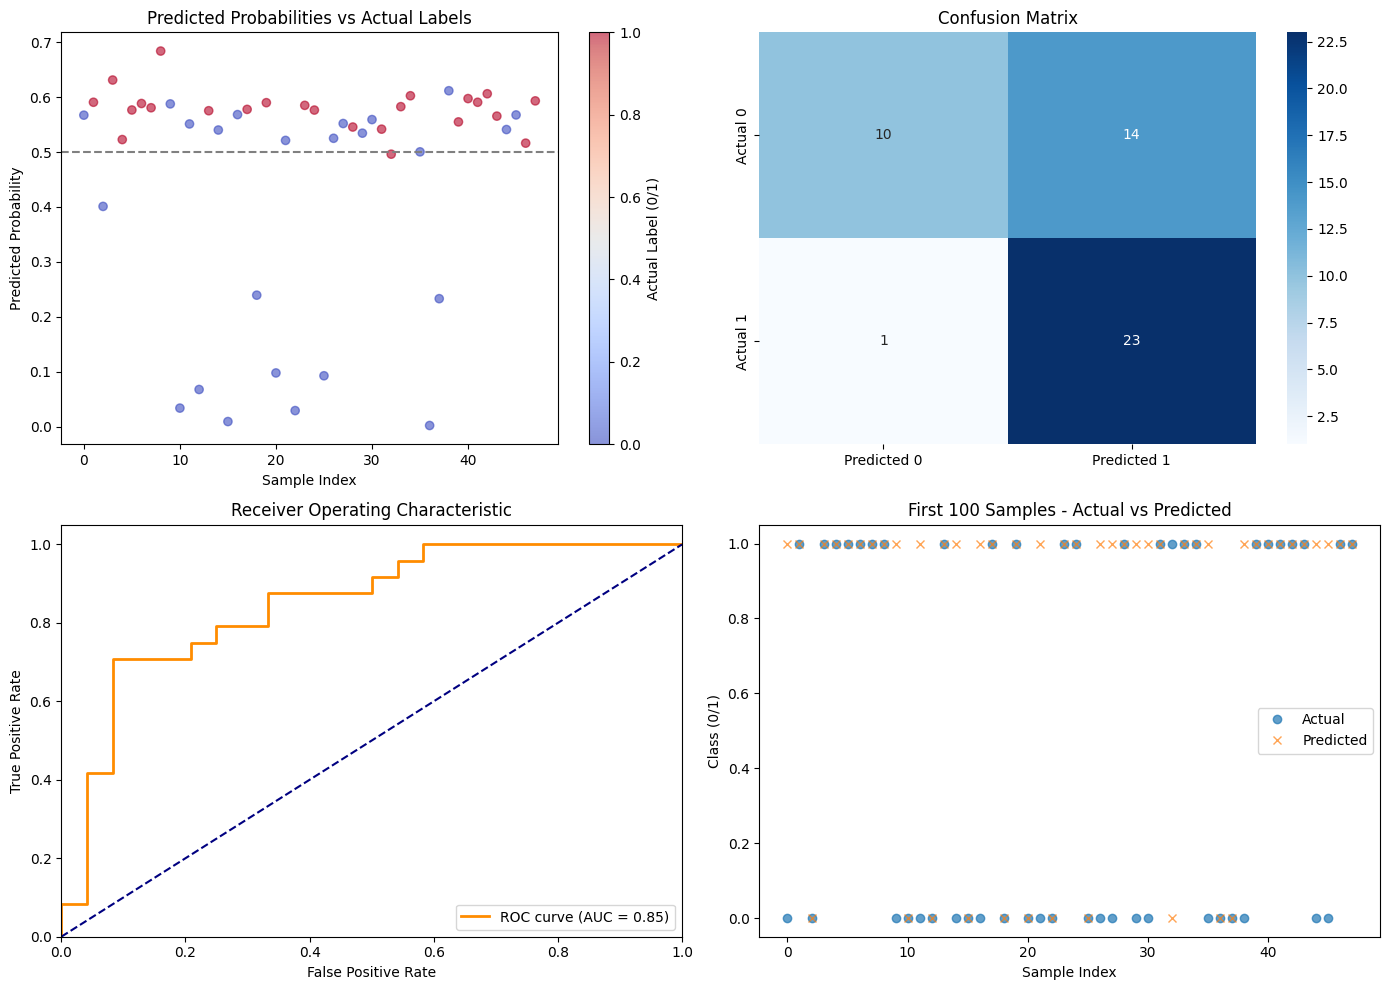

In [13]:
plot_predictions(model, data_module)

### Learning curves

In [133]:
def plot_metrics(model):
    epochs = range(len(model.train_losses))
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, model.train_losses, label='Train Loss')
    plt.plot(epochs, model.val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, model.train_accs, label='Train Accuracy')
    plt.plot(epochs, model.val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [134]:
# removing first entries of the validation logs as these are not relevant to the learning curves
# they're the random initialised values
del model.val_losses[0]
del model.val_accs[0]

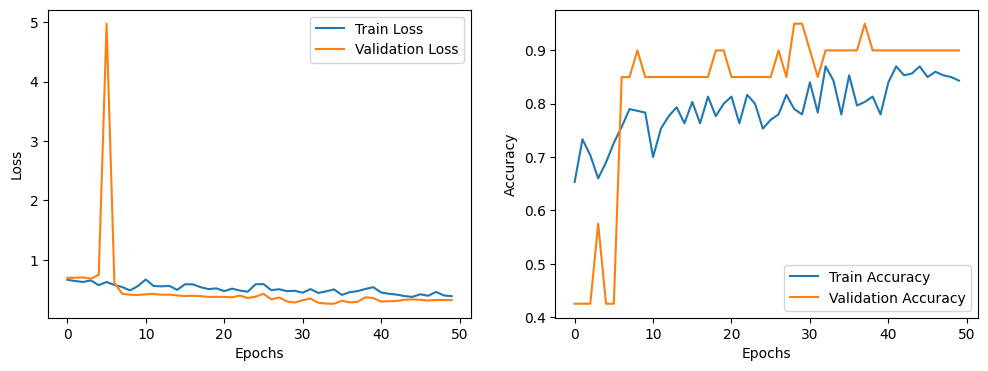

In [135]:
plot_metrics(model)

Learning curves are good for tracking how well the model progresses overtime. This is mainly to see if the model steadily improved, and to see if it has underfitted or overfitted to the data. In this case, It seems the model hasn't apparently overfitted to the data, but the jagged training implies its difficulty in adjusting to the data. Check out the figure below for ideal learning curves.

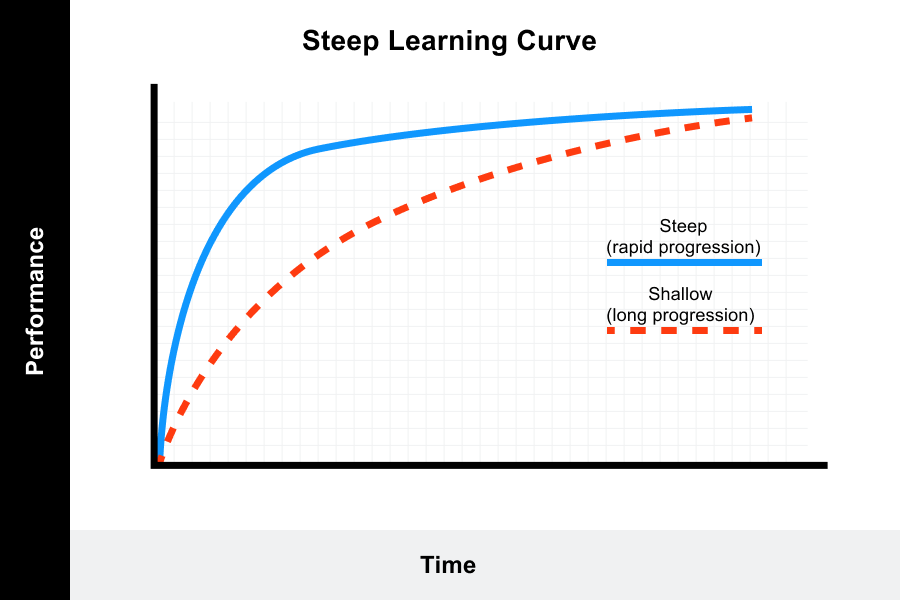